<a href="https://colab.research.google.com/github/zhouchun0105/Fake-News-Detection-Project-BA865/blob/main/NOTEBOOK_BA865_Fake_News_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
# Importing all necessary libraries and imports

# Basics
import numpy as np
import pandas as pd
from collections import Counter

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


# sklearn
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# NLTK 
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


try:
    from scikeras.wrappers import KerasRegressor                     
except ImportError:
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.2
    Uninstalling importlib-metadata-4.11.2:
      Successfully uninstalled importlib-metadata-4.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


# Setup and Data Cleaning

In [ ]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Import data 
df_fakenews_true = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/True.csv")
df_fakenews_fake = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/Fake.csv")

In [ ]:
df_fakenews_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
df_fakenews_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
df_fakenews_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
df_fakenews_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
print(df_fakenews_true.shape)
print(df_fakenews_fake.shape)

(21417, 4)
(23481, 4)


In [ ]:
# checking for any null values
df_fakenews_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
# checking for any null values
df_fakenews_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

# Data Pre-Processing

In [ ]:
# creating new colum 'Real/Fake', labeling the two datasets in order to merge and know which observation is real and which one is false
df_fakenews_true['real/fake'] = '1'
df_fakenews_fake['real/fake'] = '0'

In [ ]:
# merging the two datasets
frames = [df_fakenews_true, df_fakenews_fake]
news_data_all = pd.concat(frames)
news_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   real/fake  44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [ ]:
# Removing all links and the headline from the date column
news_data_all = news_data_all[news_data_all.date.str.contains('Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec')]

In [ ]:
# Converting the Date Column to a different Datetime format for our EDA
news_data_all['date'] = pd.to_datetime(news_data_all['date']).dt.date

In [ ]:
news_data_all.head()

,title,text,subject,date,real/fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1


In [ ]:
news_data_all.describe()

,title,text,subject,date,real/fake
count,44888,44888,44888,44888,44888
unique,38723,38640,8,1010,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,2017-12-20,0
freq,14,627,11272,197,23471


In [ ]:
# Keeping the subject column in the 'news_data_all' dataframe for EDA before dropping
news_data = news_data_all

In [ ]:
# dropping subject column as subjects across fake and real news articles are unbalanced
news_data = news_data.drop('subject', axis=1)

In [ ]:
# title and text can be two seperate variables
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44888 non-null  object
 1   text       44888 non-null  object
 2   date       44888 non-null  object
 3   real/fake  44888 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [133]:
# looking at the real news articles and seeing 'Reuters' tag
print(df_fakenews_true.loc[df_fakenews_true.text.str.contains('Reuters')].count()/df_fakenews_true.count())
print(df_fakenews_fake.loc[df_fakenews_fake.text.str.contains('Reuters')].count()/df_fakenews_fake.count())

title        0.998179
text         0.998179
subject      0.998179
date         0.998179
real/fake    0.998179
dtype: float64
title        0.013245
text         0.013245
subject      0.013245
date         0.013245
real/fake    0.013245
dtype: float64


In [ ]:
# extracting the 'Reuters' tag from the Real Articles
# news_data.text = news_data.text.str.replace('Reuters', '')

In [ ]:
# merging the title and news text
news_data['content'] = news_data['title']+' '+news_data['text']
news_dataset = news_data[['real/fake', 'date', 'content', 'title', 'text']]

In [ ]:
news_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   real/fake  44888 non-null  object
 1   date       44888 non-null  object
 2   content    44888 non-null  object
 3   title      44888 non-null  object
 4   text       44888 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [ ]:
# shuffling the cleaned dataset
news_dataset = news_dataset.sample(frac=1).reset_index(drop=True)

shuffled_indices = np.arange(news_dataset.shape[0])
np.random.shuffle(shuffled_indices)

news_dataset = news_dataset.loc[shuffled_indices]

news_dataset.describe(include='all')

,real/fake,date,content,title,text
count,44888,44888,44888,44888,44888
unique,2,1010,39099,38723,38640
top,0,2017-12-20,Highlights: The Trump presidency on April 13 a...,Factbox: Trump fills top jobs for his administ...,
freq,23471,197,8,14,627


In [ ]:
news_dataset.head(10)

,real/fake,date,content,title,text
11192,1,2017-12-19,Germany could send more soldiers to Afghanista...,Germany could send more soldiers to Afghanista...,"MAZAR-I-SHARIF, Afghanistan (Reuters) - German..."
31489,1,2017-09-24,"I'm no populist, says new leader of Italy's 5-...","I'm no populist, says new leader of Italy's 5-...","RIMINI, Italy (Reuters) - The new leader of It..."
41382,1,2017-11-16,Dublin hopeful Northern Ireland talks can resu...,Dublin hopeful Northern Ireland talks can resu...,DUBLIN (Reuters) - The Irish government is hop...
23572,0,2017-02-07,Great Britain’s Government Just Issued An EPI...,Great Britain’s Government Just Issued An EPI...,Donald Trump is scheduled to make his first st...
23462,1,2017-11-13,British PM May pledges to protect Europe from ...,British PM May pledges to protect Europe from ...,LONDON (Reuters) - British Prime Minister Ther...
20588,1,2016-11-26,Vice President-elect Pence says 'new hope dawn...,Vice President-elect Pence says 'new hope dawn...,WASHINGTON (Reuters) - U.S. Vice President-ele...
15199,0,2015-05-19,“DIFFICULT” CHELSEA CLINTON CAUSES HIGH TURNOV...,“DIFFICULT” CHELSEA CLINTON CAUSES HIGH TURNOV...,Like mother like daughter? Chelsea is very di...
38039,0,2016-07-03,ISIS’ Blasphemous Ramadan Attacks Prove They’...,ISIS’ Blasphemous Ramadan Attacks Prove They’...,Ramadan is a holy month that all Muslims celeb...
6194,0,2016-04-04,WATCH: Justin Timberlake Just Made A Joke Abo...,WATCH: Justin Timberlake Just Made A Joke Abo...,Justin Timberlake gave a speech at the 2016 iH...
41231,1,2016-08-22,"Judge orders State Department to review 14,900...","Judge orders State Department to review 14,900...",WASHINGTON (Reuters) - A judge ordered the U.S...


# Text Processing

In [ ]:
import re
import string

News-Punctuation Cleaning

In [ ]:
#Creating a copy 
clean_news=news_dataset.copy()

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
    


In [ ]:
clean_news['content'] = clean_news['content'].apply(lambda x:review_cleaning(x))
clean_news['title'] = clean_news['title'].apply(lambda x:review_cleaning(x))
clean_news['text'] = clean_news['text'].apply(lambda x:review_cleaning(x))
clean_news.head()

,real/fake,date,content,title,text
11192,1,2017-12-19,germany could send more soldiers to afghanista...,germany could send more soldiers to afghanista...,mazarisharif afghanistan reuters germany s de...
31489,1,2017-09-24,im no populist says new leader of italys rimi...,im no populist says new leader of italys,rimini italy reuters the new leader of italy ...
41382,1,2017-11-16,dublin hopeful northern ireland talks can resu...,dublin hopeful northern ireland talks can resu...,dublin reuters the irish government is hopefu...
23572,0,2017-02-07,great britain’s government just issued an epi...,great britain’s government just issued an epi...,donald trump is scheduled to make his first st...
23462,1,2017-11-13,british pm may pledges to protect europe from ...,british pm may pledges to protect europe from ...,london reuters british prime minister theresa...


News-Stop words

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# removing english stopwords to save space and processing time
stop = stopwords.words('english')
clean_news['content'] = clean_news['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,real/fake,date,content,title,text
11192,1,2017-12-19,germany could send soldiers afghanistan defens...,germany could send more soldiers to afghanista...,mazarisharif afghanistan reuters germany s de...
31489,1,2017-09-24,im populist says new leader italys rimini ital...,im no populist says new leader of italys,rimini italy reuters the new leader of italy ...
41382,1,2017-11-16,dublin hopeful northern ireland talks resume c...,dublin hopeful northern ireland talks can resu...,dublin reuters the irish government is hopefu...
23572,0,2017-02-07,great britain’s government issued epic fk trum...,great britain’s government just issued an epi...,donald trump is scheduled to make his first st...
23462,1,2017-11-13,british pm may pledges protect europe russian ...,british pm may pledges to protect europe from ...,london reuters british prime minister theresa...


In [ ]:
clean_news['real/fake'] = clean_news['real/fake'].astype(int)

In [ ]:
clean_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 11192 to 29922
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   real/fake  44888 non-null  int64 
 1   date       44888 non-null  object
 2   content    44888 non-null  object
 3   title      44888 non-null  object
 4   text       44888 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


# EDA

(-0.5, 1299.5, 949.5, -0.5)

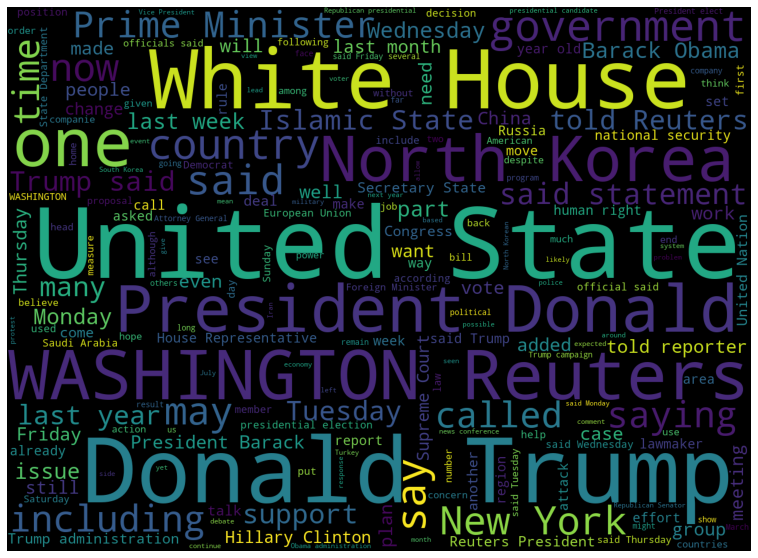

In [ ]:
# word cloud for the text real true News
text_true = pd.Series(df_fakenews_true['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_true.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 1299.5, 949.5, -0.5)

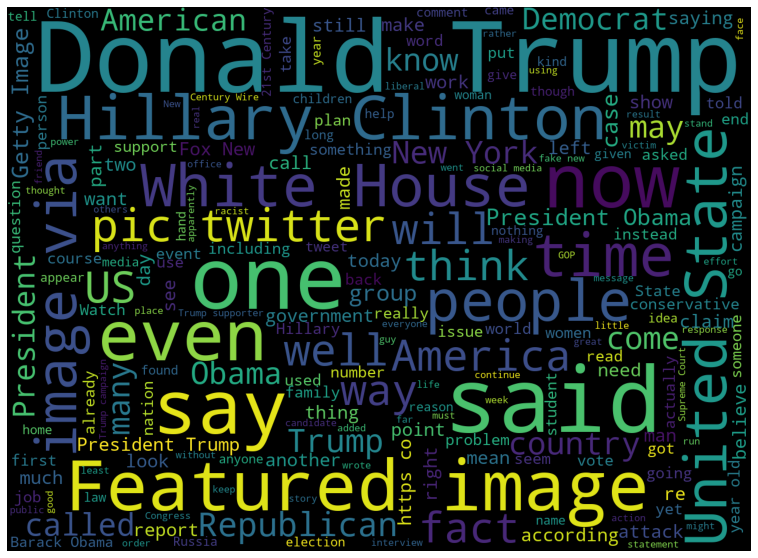

In [ ]:
# word cloud for the text false fake News
text_false = pd.Series(df_fakenews_fake['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_false.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
# subsetting the cleaned, preprocessed news data for real and fake
top_words = clean_news.copy()
top_words_real = top_words[top_words['real/fake'] == 1]
top_words_fake = top_words[top_words['real/fake'] == 0]

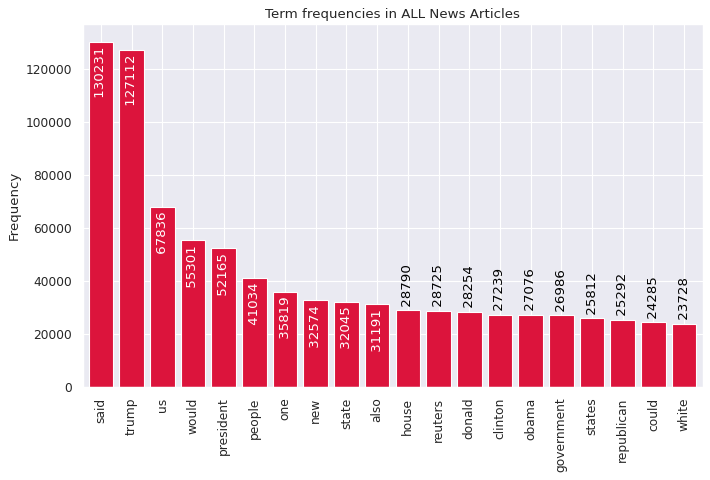

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(top_words['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in ALL News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
#plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

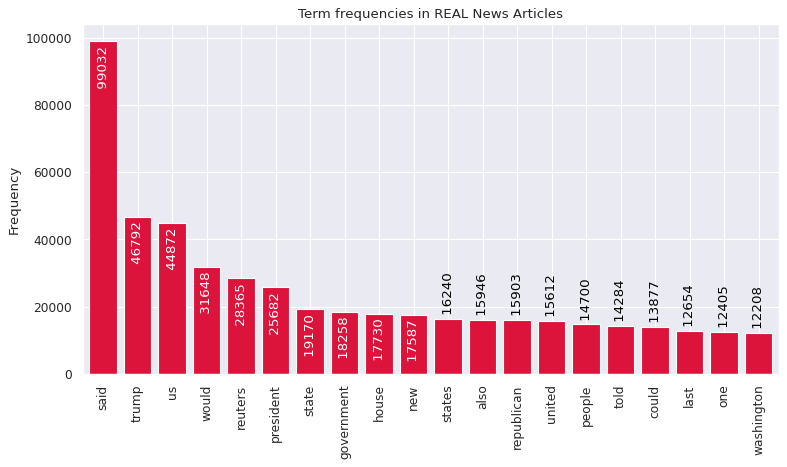

In [ ]:
figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(top_words_real['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in REAL News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

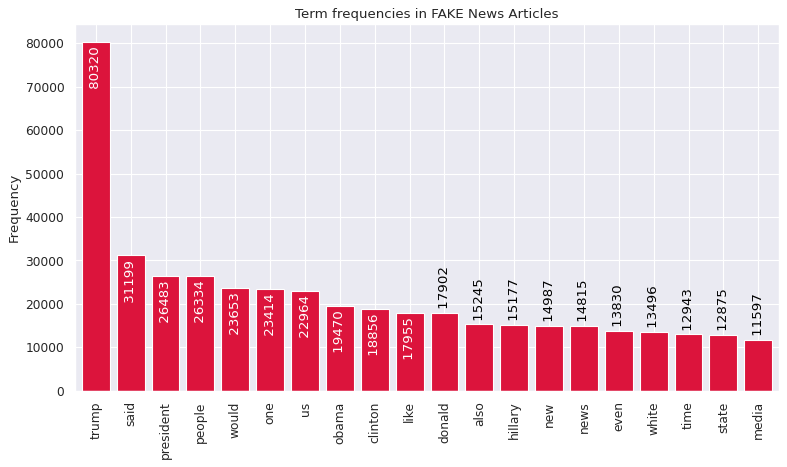

In [ ]:
figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(top_words_fake['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in FAKE News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

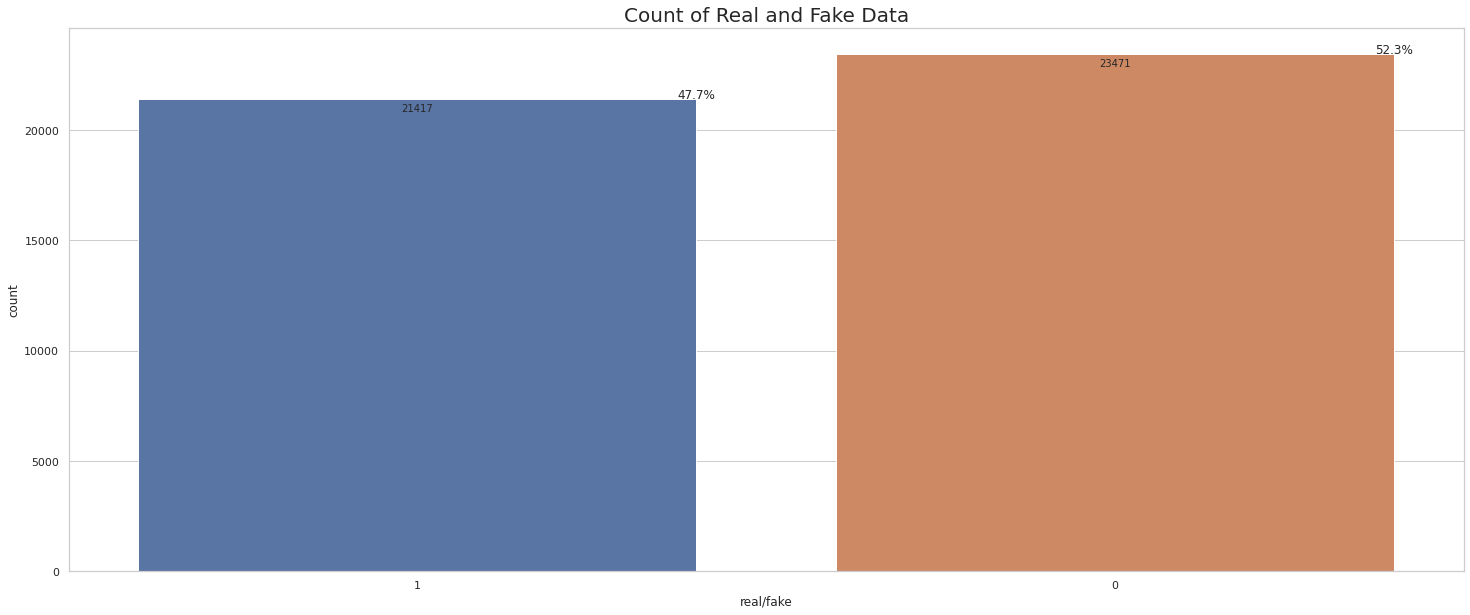

In [ ]:
total = float(len(news_data))

sns.set_style('whitegrid')
plt.figure(figsize= (25,10))
fig = sns.countplot(x='real/fake', data= news_data)
plt.title('Count of Real and Fake Data', fontsize=20)
for p in fig.patches:
    fig.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -10), 
                   textcoords = 'offset points')
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    fig.annotate(percentage, (x, y),ha='center')

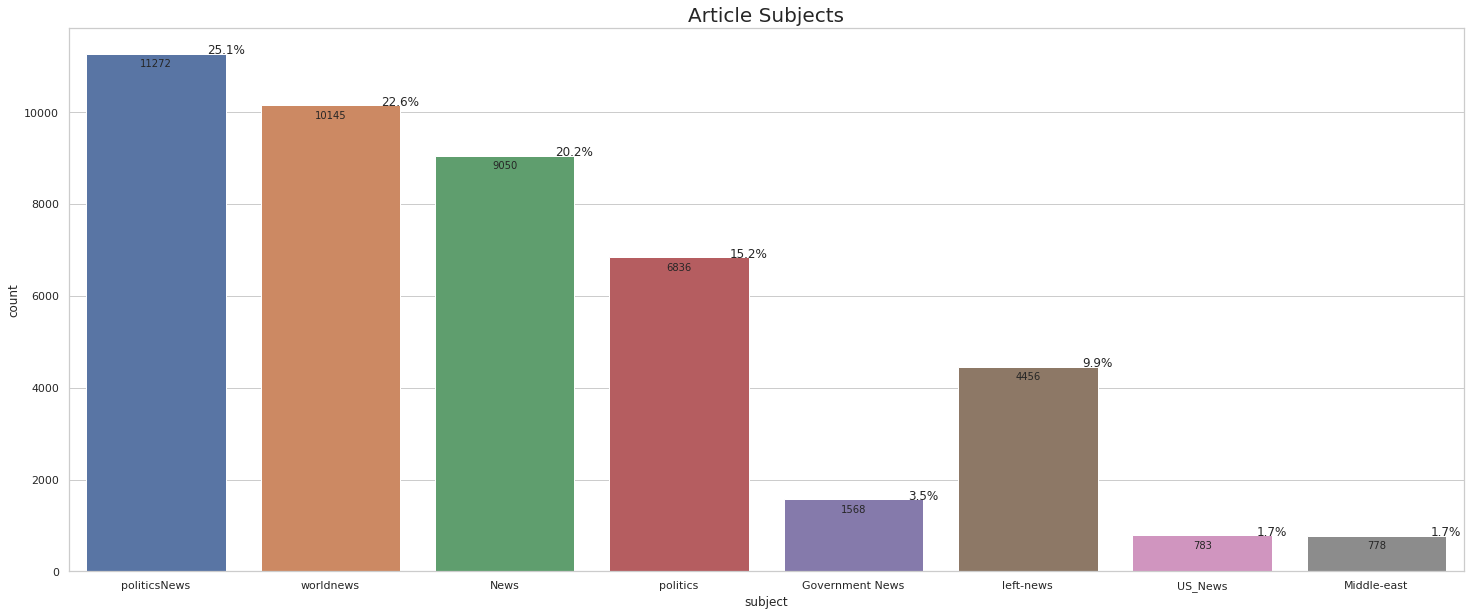

In [ ]:
#order=['unknown','Activated','Pending Activation','Inactivated','Non Standard MyChart Status','Patient Declined','Activation Code Generated, but Disabled']
total = float(len(news_data))


plt.figure(figsize= (25,10))
fig = sns.countplot(x='subject', data= news_data_all)
plt.title('Article Subjects', fontsize=20)
for p in fig.patches:
    fig.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -10), 
                   textcoords = 'offset points')
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    fig.annotate(percentage, (x, y),ha='center')


In [ ]:
count = news_data_all.groupby(['subject','real/fake']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()
count

,subject,real/fake,count
0,politicsNews,1,11272
1,worldnews,1,10145
2,News,0,9050
3,politics,0,6836
4,left-news,0,4456
5,Government News,0,1568
6,US_News,0,783
7,Middle-east,0,778


In [ ]:
df_fakenews_true.groupby(['subject']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()

,subject,count
0,politicsNews,11272
1,worldnews,10145


In [ ]:
df_fakenews_fake.groupby(['subject']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()

,subject,count
0,News,9050
1,politics,6841
2,left-news,4459
3,Government News,1570
4,US_News,783
5,Middle-east,778


Time Serires Real/Fake News

In [ ]:
# looking at the publication date timespan of all articles
print(news_data_all['date'].min())
print(news_data_all['date'].max())

2015-03-31
2018-02-19


In [ ]:
df = news_data.groupby(['real/fake','date']).size().to_frame('count').reset_index()

In [ ]:
df.head()

,real/fake,date,count
0,0,2015-03-31,8
1,0,2015-04-01,2
2,0,2015-04-02,1
3,0,2015-04-04,5
4,0,2015-04-05,13


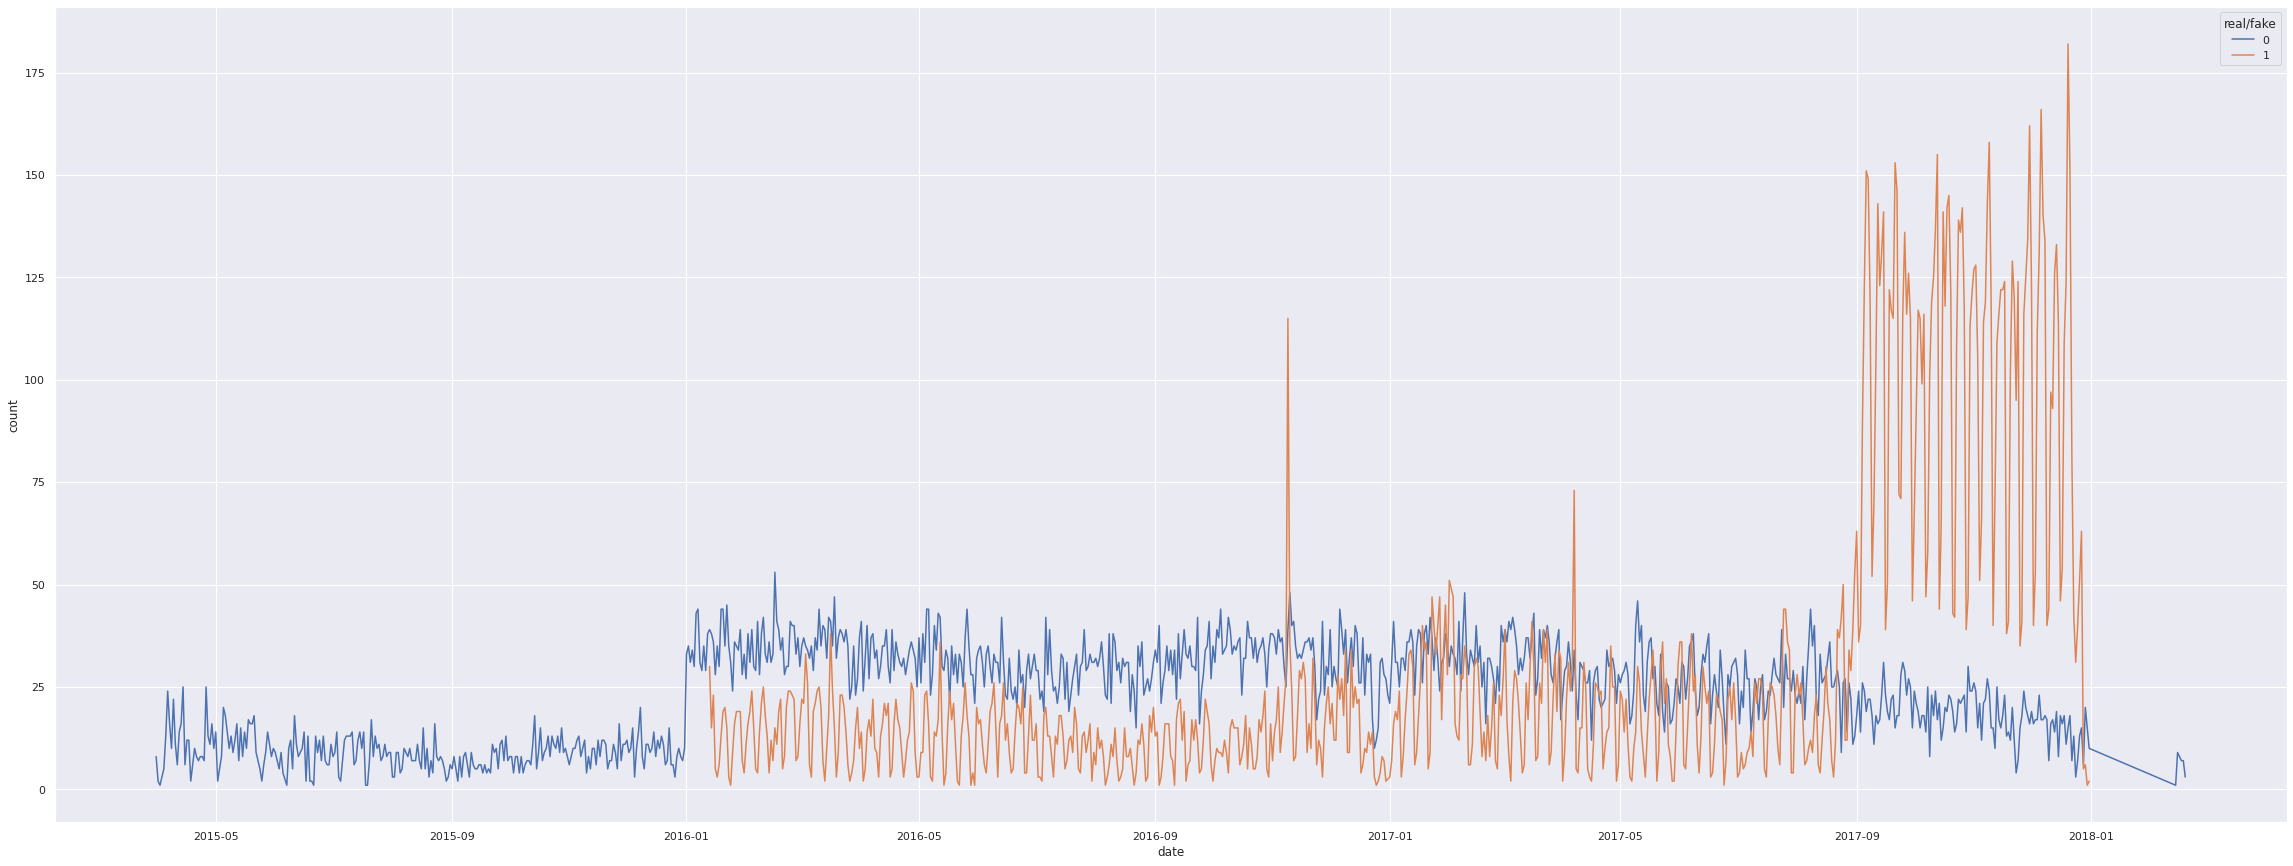

In [ ]:
sns.set(rc={'figure.figsize':(40,15)})
sns.lineplot(data=df, x='date', y='count', hue='real/fake')

# Embedding using Stemming

Going through a stemming process, which will group together the inflected forms of a word so they can be analyzed as a single item: the stem. 

In [ ]:
# Feature extraction 'reviews' for processing
news_features = clean_news.copy()
news_features = news_features[['content']].reset_index(drop=True)
news_features.head()

,content
0,germany could send soldiers afghanistan defens...
1,im populist says new leader italys rimini ital...
2,dublin hopeful northern ireland talks resume c...
3,great britain’s government issued epic fk trum...
4,british pm may pledges protect europe russian ...


In [ ]:
#Defining Stopwords
stop_words = set(stopwords.words("english"))

#Performing stemming on the review dataframe
ps = PorterStemmer()

#Splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['content'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news) #Getting the target variable

**CHECK FOR AVERAGE LENGTH OF EACH TEXT 6.5, not sure if this is right**

Before we proceed, do we expect a Sequence model to be helpful here (versus a bag of words model)? Recall, we should check the ratio of observations in training to mean number of tokens per sample. We don't expect to get much value at all from a sequential text model in this case, because we would need a much bigger dataset (on the order of 2.5 million observations).

In [ ]:
lengths = [len(x) for x in corpus]

print(f'The average article in our data has {np.mean(lengths)} words, and we have {len(clean_news)} samples.')
print(f'The ratio of samples to average sample length is thus {len(clean_news)/np.mean(lengths)}. We are nowhere close to 1500.')

The average article in our data has 1554.6395250401 words, and we have 44888 samples.
The ratio of samples to average sample length is thus 28.873574405515114. We are nowhere close to 1500.


One-Hot encoding for the embedding layers

In [ ]:
#Setting up vocabulary size
voc_size = 12000

#One hot encoding 
onehot_repr = [one_hot(words,voc_size)for words in corpus]

Padding embedded docs

In [ ]:
#Setting sentence length
sent_length = 6000

#Padding the sentences
embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length)
print(embedded_docs)

[[    0     0     0 ...  3846  6836  2657]
 [    0     0     0 ...  7659   770    10]
 [    0     0     0 ... 10261  2659   600]
 ...
 [    0     0     0 ...  3849 11129  7038]
 [    0     0     0 ... 10371  1473  2762]
 [    0     0     0 ... 10241  7315  7038]]


## Model with one input and CV (TITLE AND TEXT COMBINDED)

LSTM Model

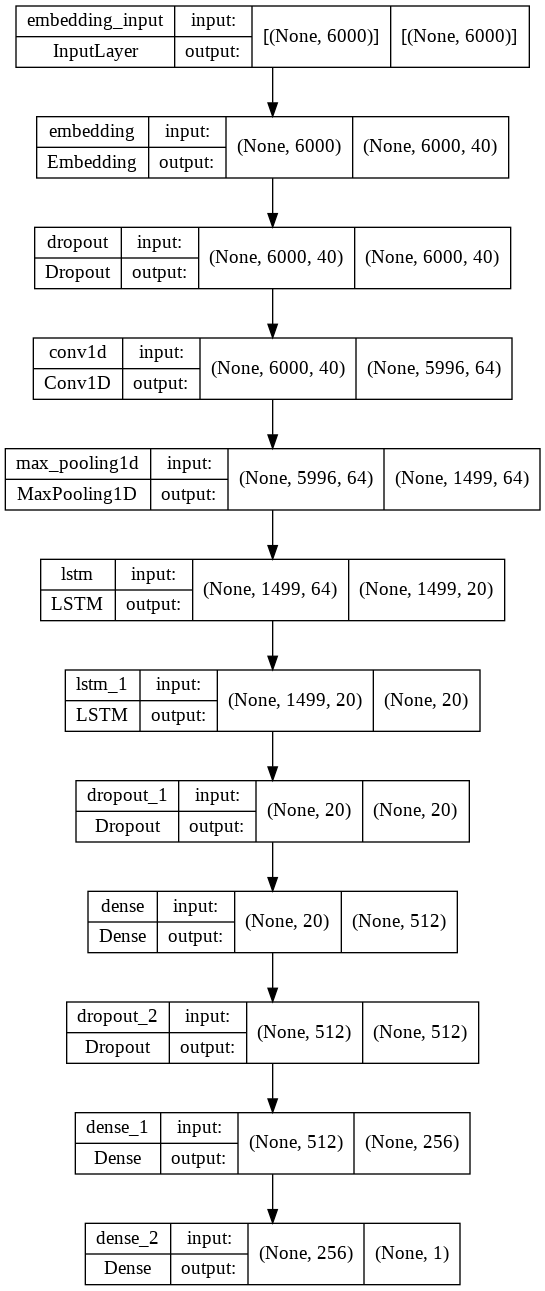

In [ ]:
# building a model
def build_model():

    embedding_vector_features=40

    model = keras.Sequential([
        keras.layers.Embedding(voc_size,embedding_vector_features,input_length=sent_length),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(64, 5, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=4),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.LSTM(20),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    return model

model = build_model()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
  # Displaying the model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6000, 40)          480000    
                                                                 
 dropout (Dropout)           (None, 6000, 40)          0         
                                                                 
 conv1d (Conv1D)             (None, 5996, 64)          12864     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1499, 64)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1499, 20)          6800      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                        

Fitting the Model

In [ ]:
# Defining the label column
label = clean_news['real/fake']

# Converting the X and y as array
text = np.asarray(embedded_docs).astype("float32")
label = np.asarray(label).astype("float32")

# Checking shape of X and y
text.shape,label.shape

((44888, 6000), (44888,))

In [ ]:
# Checking how much of the data to take out for the testing dataset (validation)
holdout_split = int(len(label)*0.33)

In [ ]:
# defining train and test data
data_train = text[:holdout_split]
labels_train = label[:holdout_split]
data_test = text[holdout_split:]
labels_test = label[holdout_split:]

In [112]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 5
batch_sizes = 100
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/5
75/75 [==============================] - 322s 4s/step - loss: 0.4634 - accuracy: 0.7384 - val_loss: 0.1787 - val_accuracy: 0.9346
Epoch 2/5
75/75 [==============================] - 297s 4s/step - loss: 0.1079 - accuracy: 0.9689 - val_loss: 0.0917 - val_accuracy: 0.9708
Epoch 3/5
75/75 [==============================] - 291s 4s/step - loss: 0.0332 - accuracy: 0.9926 - val_loss: 0.0541 - val_accuracy: 0.9842
Epoch 4/5
75/75 [==============================] - 295s 4s/step - loss: 0.0167 - accuracy: 0.9964 - val_loss: 0.1298 - val_accuracy: 0.9676
Epoch 5/5
75/75 [==============================] - 293s 4s/step - loss: 0.0090 - accuracy: 0.9980 - val_loss: 0.0599 - val_accuracy: 0.9869
Epoch 1/5
75/75 [==============================] - 299s 4s/step - loss: 0.4799 - accuracy: 0.7247 - val_loss: 0.1694 - val_accuracy: 0.9421
Epoch 2/5
75/75 [==============================] - 313s 4s/step - loss: 0.0808 - accuracy: 0.9776 - val_loss: 0.0850 - val_accuracy: 0.9733
Epoch 3/5
75/75 [===

Plotting Model Performance and evaluating against Test Set

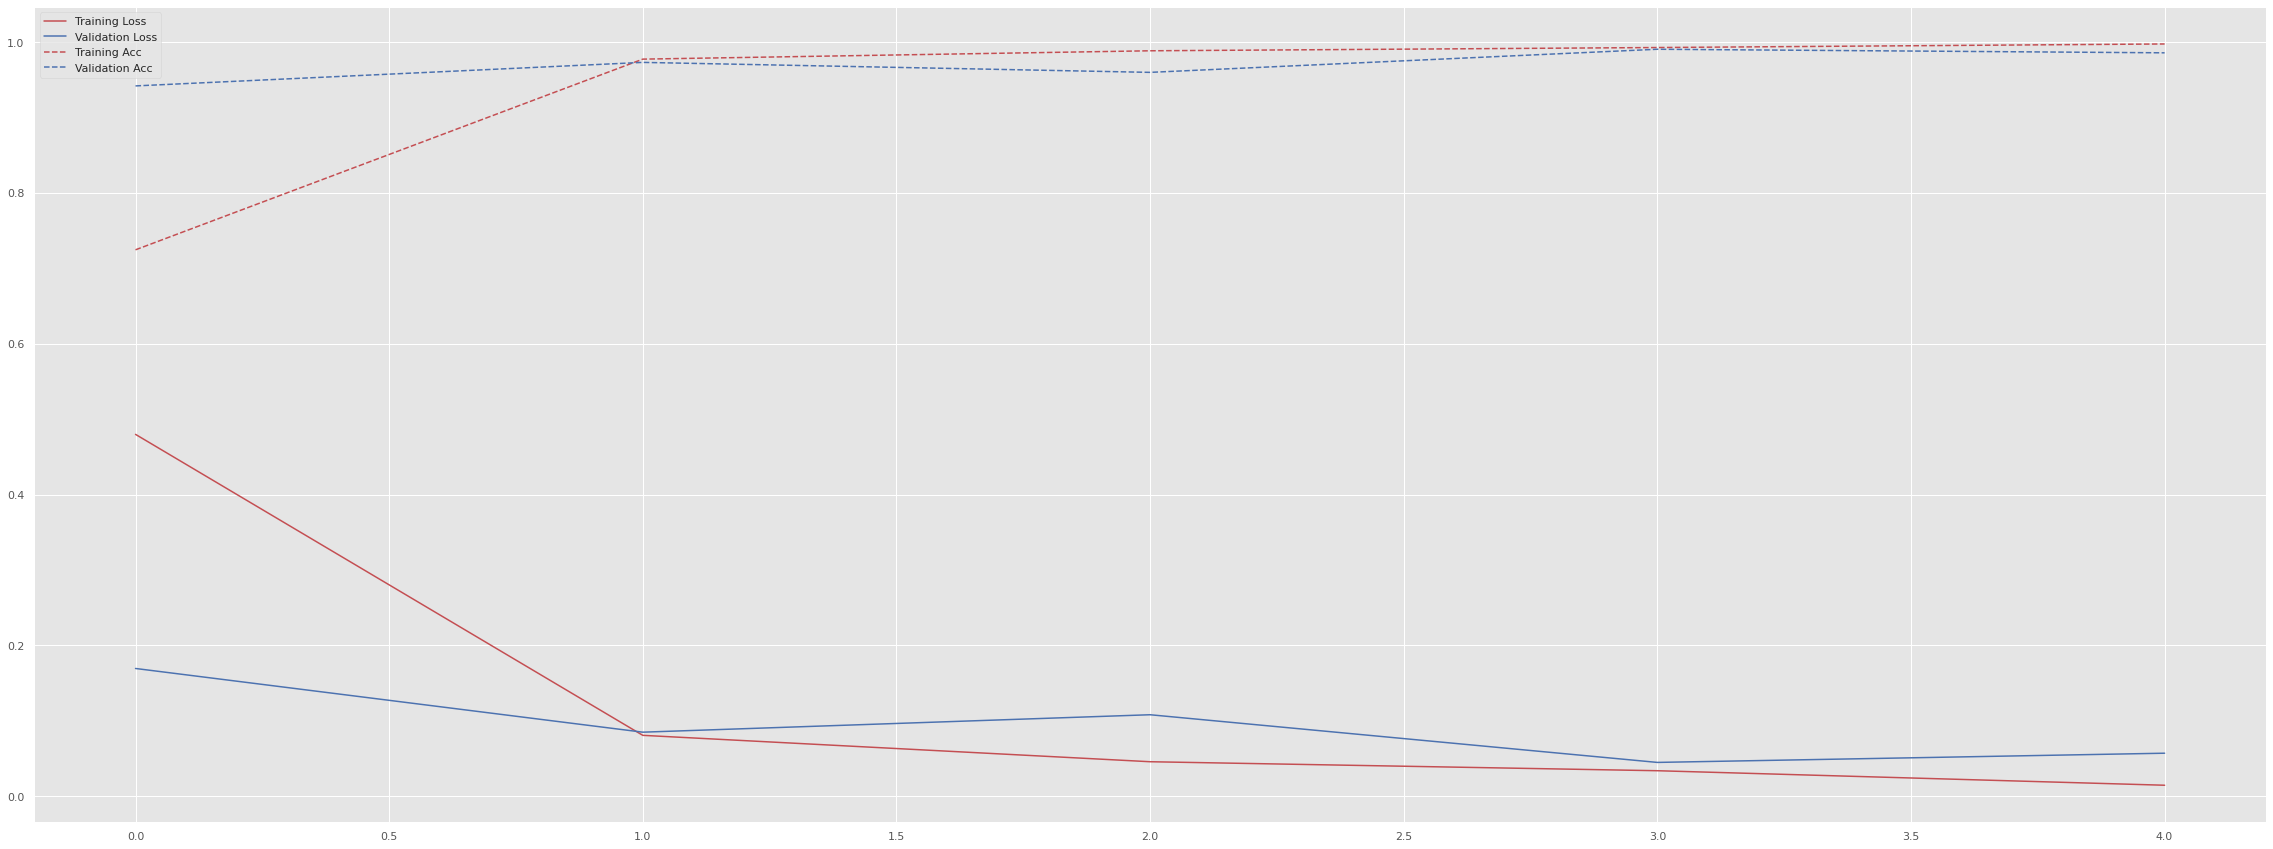

940/940 [==============================] - 281s 299ms/step - loss: 0.0486 - accuracy: 0.9875
Test acc: 0.987


In [113]:
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()

print(f"Test acc: {model.evaluate(data_test, labels_test)[1]:.3f}")

Evaluation of the model

Let's see how we do on the holdout sample though. But wait! We dropped several features from the original dataset that we used last time. We might want to incorporate those other features into another branch of the network (another input layer).

In [115]:
test_acc = model.evaluate(data_test, labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

940/940 [==============================] - 374s 395ms/step - loss: 0.4508 - accuracy: 0.8636
The resulting model is about 86.36% accurate in the holdout sample.


## Bi-directional LSTM

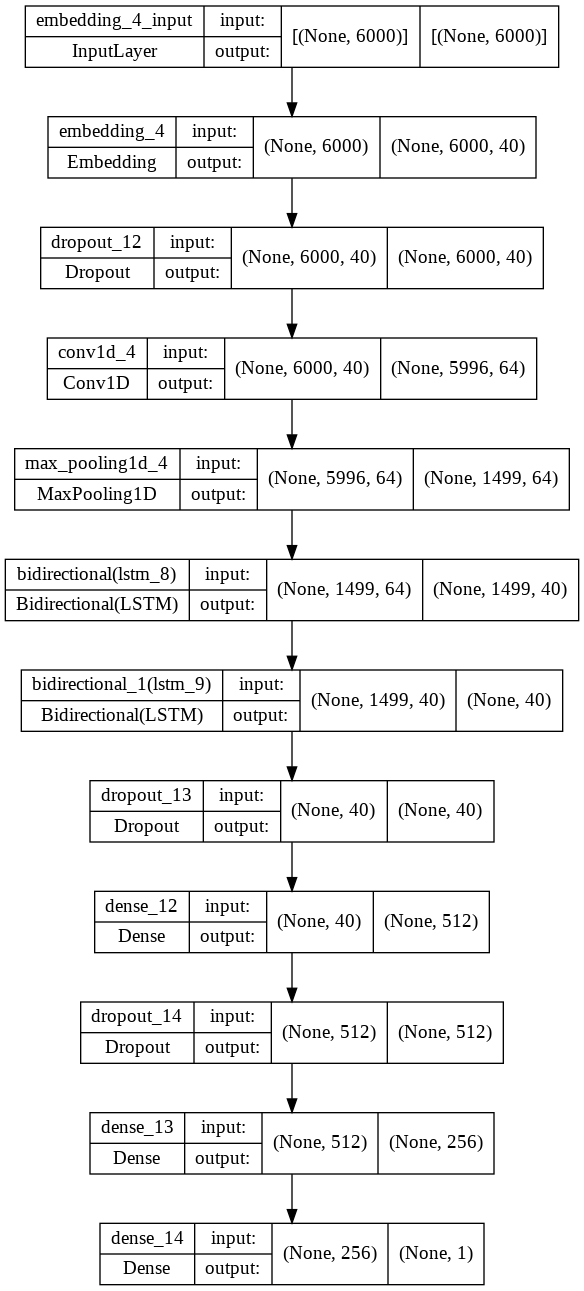

In [116]:
# building a model
def build_model():

    embedding_vector_features=40

    model = keras.Sequential([
        keras.layers.Embedding(voc_size,embedding_vector_features,input_length=sent_length),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(64, 5, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=4),
        keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(20)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    return model

model = build_model()
keras.utils.plot_model(model, show_shapes=True)

In [117]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 5
batch_sizes = 100
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/5
 8/75 [==>...........................] - ETA: 5:45 - loss: 0.6938 - accuracy: 0.5138

KeyboardInterrupt: ignored

Plotting Model Performance and evaluating against Test Set

In [ ]:
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()

print(f"Test acc: {model.evaluate(data_test,labels_test)[1]:.3f}")

## Multi Input Model with CV 

# Embedding using GloVe



## Model with one input

In [ ]:
#Getting the zip
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-09 02:25:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-09 02:25:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-09 02:25:50--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

BIDIRECTIONAL LSTM LAYER

In [ ]:
#Finding vectors 
import numpy as np
path_to_glove_file = "glove.6B.100d.txt" 
  
embeddings_index = {} 
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) # Split off only the first element in the row, i.e., the word, keep the remaining values as the vector.
        coefs = np.fromstring(coefs, "f", sep=" ") # Convert the set of numeric values into a numpy array, splitting elements by ' '
        embeddings_index[word] = coefs # Populate our dictionary - for this word (key), the vector representation is this vector (value).
  
glove_vec_lengths = len(coefs)

print(f"Found {len(embeddings_index)} word vectors.")
print(f"GloVe vector representations are {glove_vec_lengths} elements long.")

Found 400000 word vectors.
GloVe vector representations are 100 elements long.


In [ ]:
##Text to integer encoding
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, 
    output_mode="int",
)

text_vectorization.adapt(clean_news['content'])

In [ ]:
#Vector representation of the merged text and title column
review_text = clean_news.loc[0,'content']
print(f'REVIEW TEXT: \n\n{review_text}')
review_len = len(review_text.replace(',',''))
print(f'REVIEW DETAILS: \n\nThe review contains roughly {review_len} words (based on white spaces).')
vectorized_review = text_vectorization(clean_news.loc[0,'content']).numpy()
print(f'It\'s vectorized form contains {vectorized_review.shape[0]} tokens.\n') 
print(f'VECTOR REPRESENTATION:\n')
vectorized_review

REVIEW TEXT: 

germany issues arrest warrant syrian bomb plot suspect berlin reuters german federal judge issued arrest warrant wednesday syrian man detained suspicion planning bombing attack public prosecutor office gba said statement police detained man identified yamen german privacy laws tuesday prosecutors said believe planned islamistmotivated bomb attack aim killing many people possible contact online jihadists including one described soldier caliphate spokeswoman federal prosecutor office said yamen arrested northeastern town schwerin police searched home also people suspected directly involved arrest comes one month first anniversary attack berlin failed tunisian asylum seeker killed people plowing truck christmas market concrete blocks installed around christmas markets several central squares capital year festive season opens couple weeks
REVIEW DETAILS: 

The review contains roughly 846 words (based on white spaces).
It's vectorized form contains 111 tokens.

VECTOR REPRESE

array([ 541,  322, 1204,    1,  365, 1383,    1, 1682, 1712,   13,  784,
         81,  330,  750, 1204,    1,  110,  365,  141, 1550,    1, 1462,
          1,  163,   82, 1457,   84,    1,    2,   89,   47, 1550,  141,
       1435,    1,  784,    1,  587,  100, 1316,    2,  220,  568,    1,
       1383,  163,    1, 1020,   39,    7,  331, 1764,  980,    1,   72,
          8,  825,    1,    1,  888,   81, 1457,   84,    2,    1,  634,
          1,  776,    1,   47,    1,  219,   11,    7, 1490, 1135,  612,
       1204,  420,    8,  173,   32,    1,  163, 1712,  524,    1, 1688,
          1,  236,    7,    1,    1, 1891,  675,    1,    1,    1,  142,
       1891, 1674,  194,  553,    1,  482,   37,    1,    1,    1, 1324,
        452])

In [ ]:
#Getting the vocabulary
vocabulary = text_vectorization.get_vocabulary()
print(f"Recall that our vocabulary has {len(vocabulary)} tokens in it.")
print(f"Here is the 11th word in our vocabulary: {vocabulary[13]}.") 

Recall that our vocabulary has 2000 tokens in it.
Here is the 11th word in our vocabulary: reuters.


In [ ]:
embedding_dim = glove_vec_lengths 

vocabulary = text_vectorization.get_vocabulary() 
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Instantiate a matrix of values 
embedding_matrix = np.zeros((len(vocabulary), embedding_dim)) 
for word, i in word_index.items():
    if i < len(vocabulary):
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#Testing the matrix
embedding_matrix[13]

array([-0.37518001, -0.75599998, -0.15465   , -0.32001999, -0.071822  ,
       -0.77529001,  0.33215001, -0.32890001,  0.13287   ,  0.56300998,
        0.61298001, -0.021408  ,  0.70045   , -1.05729997, -0.045666  ,
       -0.11477   , -0.18948001, -0.84996003,  0.068737  , -0.12273   ,
       -0.032676  , -0.41442001, -0.066694  ,  0.57108998,  0.55372   ,
       -1.30120003,  0.53166002,  0.31603   , -0.2304    , -0.057812  ,
        0.57336998,  0.47165999, -1.0977    , -0.077163  , -0.0076298 ,
       -0.10071   , -0.18689001,  0.89956999,  0.47779   ,  0.14157   ,
       -0.17012   ,  0.59797001, -1.12199998,  0.65860999, -0.71008998,
       -0.14211001, -0.37173   , -0.40476   , -0.52621001, -0.85141999,
        0.54205   ,  0.77373999,  0.30274999,  0.53210002, -0.61983001,
       -0.77196002, -0.12154   , -0.35372999,  0.040635  ,  0.25459999,
        0.12892   , -0.21343   , -0.79385   , -0.31437001, -0.31399   ,
        0.57876998,  0.095732  ,  0.66071999,  0.49564999,  0.70

In [ ]:
embedding_layer = layers.Embedding(
    len(vocabulary), 
    glove_vec_lengths, 
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
    trainable=False, 
    mask_zero=True, 
)

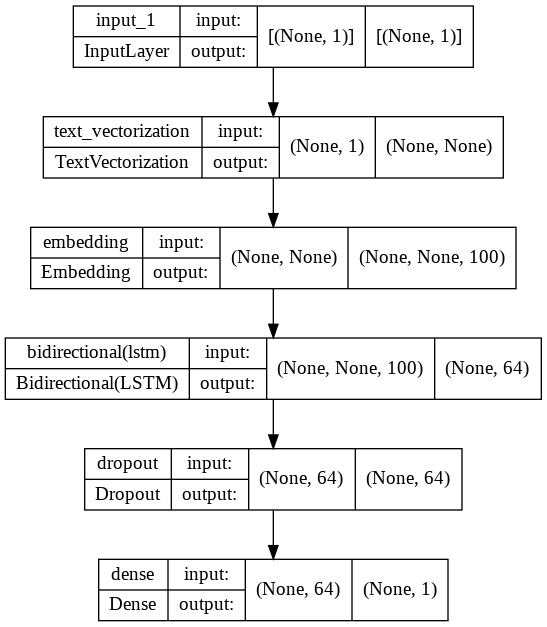

In [ ]:
def build_model_GloVe():
    inputs = keras.layers.Input(shape=(1), dtype="string")  
    processing = text_vectorization(inputs)
    
    embedding = embedding_layer(processing)
    
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_GloVe = build_model_GloVe()

keras.utils.plot_model(model_GloVe, show_shapes=True)

In [ ]:
k = 3
num_validation_samples = len(data_train) // k
num_epochs = 2
batch_sizes = 10
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model_GloVe()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]


Epoch 1/2


ValueError: ignored

## Multi Model Input

# Embedding using either SpaCy or TFIDF

## Model with one input

## Multi Model Input